In [1]:
!pip install pandas
!pip install tensorflow

In [2]:
import os
import pandas as pd
import re
import tensorflow as tf

In [3]:
data_dir = 'drive/MyDrive/Data'
document = os.listdir(data_dir)

Me-list semua text file yang ada dalam folder terkait untuk proses loading ke dalam variabel

In [183]:
data_text = {'category':[],'line':[]}
line_loaded = 0
for i in document:
    print(f"PROCESSING {i}.....")
    document_data = open(os.path.join(data_dir,i), "r")
    data_list = []
    for line in document_data:
        if "#" in line:
            continue
        data_list.append(line)
        line_loaded += 1
    document_data.close()
    for line in data_list:
        data_text['category'].append(line[:4])
        data_text['line'].append(line[4:])
    print(f'{i} HAS BEEN LOADED\n')
print(f'\n{line_loaded} TEXT LINE HAS BEEN LOADED SUCCESSFULLY')
data_text_frame = pd.DataFrame.from_dict(data_text)

PROCESSING arxiv_annotate3_80_1.txt.....
arxiv_annotate3_80_1.txt HAS BEEN LOADED

PROCESSING arxiv_annotate5_240_3.txt.....
arxiv_annotate5_240_3.txt HAS BEEN LOADED

PROCESSING arxiv_annotate3_80_3.txt.....
arxiv_annotate3_80_3.txt HAS BEEN LOADED

PROCESSING arxiv_annotate2_66_3.txt.....
arxiv_annotate2_66_3.txt HAS BEEN LOADED

PROCESSING arxiv_annotate1_13_1.txt.....
arxiv_annotate1_13_1.txt HAS BEEN LOADED

PROCESSING arxiv_annotate3_80_2.txt.....
arxiv_annotate3_80_2.txt HAS BEEN LOADED

PROCESSING arxiv_annotate10_7_2.txt.....
arxiv_annotate10_7_2.txt HAS BEEN LOADED

PROCESSING arxiv_annotate2_66_1.txt.....
arxiv_annotate2_66_1.txt HAS BEEN LOADED

PROCESSING arxiv_annotate4_168_3.txt.....
arxiv_annotate4_168_3.txt HAS BEEN LOADED

PROCESSING arxiv_annotate5_240_1.txt.....
arxiv_annotate5_240_1.txt HAS BEEN LOADED

PROCESSING arxiv_annotate1_13_3.txt.....
arxiv_annotate1_13_3.txt HAS BEEN LOADED

PROCESSING arxiv_annotate1_13_2.txt.....
arxiv_annotate1_13_2.txt HAS BEEN LOADED

Proses loading semua texfile dengan pemisahan antara bagian kategori (category) dan deskripsi (line) kedalam dataframe.

In [181]:
data_text_frame['line'] = data_text_frame['line'].apply(lambda x:" ".join(x.rstrip('\t\n').split()))
data_text_frame['category'] = data_text_frame['category'].apply(lambda x:" ".join(x.rstrip('\t\n').split()))
data_text_frame.head()

,category,line
0,MISC,defensive forecasting is a method of transform...
1,MISC,there are two known varieties of defensive for...
2,AIMX,this note shows that the randomized variety ca...
3,CONT,textbf new as compared to version NUMBER NUMBE...
4,CONT,in the case where is finite it is shown that f...


Cek dan modifikasi dataframe dengan beberapa fungsi separasi escape character untuk memastikan textfile telah termuat sesuai yang diharapkan

In [6]:
data_text_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3114 entries, 0 to 3113
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  3114 non-null   object
 1   line      3114 non-null   object
dtypes: object(2)
memory usage: 48.8+ KB


Cek jumlah data apakah ada kejanggalan seperti null value

In [7]:
data_text_frame['category'].value_counts()

MISC    1822
OWNX     867
AIMX     194
CONT     170
BASE      61
Name: category, dtype: int64

Cek jumlah kategori dalam data teks. Terlihat ada ketimpangan jumlah yang tentunya memengaruhi proses learning model (bisa jadi model cenderung mengenali kategori terbanyak daripada yang lain)

In [17]:
from typing import List
def split_data(data:object,test_size:float=0.2)->object:
    len_data = len(data)
    test_portion = int(test_size*len_data)
    test_ind = len_data - test_portion
    train_data = data.iloc[:test_ind]
    test_data = data.iloc[test_ind:]
    return train_data, test_data
training_data,prediction_data = split_data(data_text_frame,0.1)

Memisahkan antara data training dan prediction. Data training akan dibagi lagi menjadi train_data dan test_data untuk proses learning/fitting. Pembagian ini tidak dilakukan shuffle dikarenakan data teks diinterpretasikan seabgai kesatuan yang memiliki arti semantik dari satu line ke yang lain.

In [24]:
len(data_text_frame),len(training_data),len(prediction_data)

(3114, 2803, 311)

Melihat data mentah, subset training, dan subset prediksi.

In [105]:
train_data,test_data = split_data(training_data,0.1)
train_data.head()

,category,line
0,MISC,defensive forecasting is a method of transform...
1,MISC,there are two known varieties of defensive for...
2,AIMX,this note shows that the randomized variety ca...
3,CONT,textbf new as compared to version NUMBER NUMBE...
4,CONT,in the case where is finite it is shown that f...


Pembagian subset training menjadi sub-subset training (train_data) dan sub-subset testing (test_data). Pembagian tidak dilakukan shuffling dengan alasan yang sama dan penentuan porsi yang kecil (0.1) dilihat dari proses learning yang mana test_data akan dijadikan validasi data. Model akan berupaya memperbaiki kualitas akurasi dengan mempertimbangkan hasil validasi juga.

In [127]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

vocab_size = 10000
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type = 'post'
oov_tok = "<OOV>"

training_sentences = train_data['line'].values
testing_sentences = test_data['line'].values
training_labels = train_data['category'].values
testing_labels = test_data['category'].values
all_labels = data_text_frame['category'].values

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data_encoded['line'].values)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(all_labels)
training_label_seq = np.asarray(label_tokenizer.texts_to_sequences(training_labels))
testing_label_seq = np.asarray(label_tokenizer.texts_to_sequences(testing_labels))

# Pre-processing textdata

## Parameter Definition
Menetapkan parameter vocab_size (kumpulan representasi numerik dari setiap kata dalam teksdata dengan jumlah tertentu), embedding_dim (dimensional mapping untuk setiap representasi numerik dari kata dalam teks data), max_length (panjang kata yang diizinkan untuk dimuat dalam text encoding-merubah kata ket dalam numerik melalui tokenizer, trunc_type (opsi arah pemotongan text data sehingga memenuhi max length), padding_type (opsi arah penambahan leading-zero agar encoding text memenuhi max length), oov_tok (representasi numerik untuk kata yang tidak sempat direpresentasikan karena telah memenuhi vocab_size).

## Tokenizing 
Mengubah text data ke dalam representasi numerik sesuai dengan vocabulary yang telah terbuat selama fase fitting. Beberapa modifikasi seperti padding dilakukan untuk memenuhi max_length untuk setiap data text. Konversi token untuk label dilakukan dengan mengubahnya menjadi array menyesuaikan konfigurasi tensorflow sequential model.

In [133]:
training_label_seq

array([[1],
       [1],
       [3],
       ...,
       [1],
       [1],
       [1]])

In [108]:
len(training_padded), len(training_sequences)

(2523, 2523)

In [109]:
len(testing_padded), len(testing_sequences)

(280, 280)

In [110]:
len(train_data),len(training_padded) 

(2523, 2523)

In [111]:
len(test_data),len(testing_padded)

(280, 280)

In [121]:
len(label_tokenizer.word_index)

5

In [134]:
label_tokenizer.word_index

{'aimx': 3, 'base': 5, 'cont': 4, 'misc': 1, 'ownx': 2}

In [130]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(label_tokenizer.word_index)+1, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 16)           160000    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 32)                4224      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 102       
Total params: 164,854
Trainable params: 164,854
Non-trainable params: 0
_________________________________________________________________


Membangun model sekuensial dengan melibatkan Embedding layers (membuat dimensional mapping sehingga proses klasifikasi lebih robust), Bidirectional LSTM ( mempertimbangkan data sebelum dan sesudahnya dalam hal ini kata dalam data text), Dense (melakukan proses matematis dengan parameter aktivasi dan jumlah neuron), Dropout (melakukan deaktivasi layer untuk mengurangi potensi overfitting). Kompilasi dilakukan dengan memakai sparse entropy melihat output model berupa distribusi probabilitas (multiclass) target value dengan optimizer adam (kecenderungan robust yang tinggi) dan metrics accuracy (acuan penilaian/learning).

In [131]:
num_epochs = 50
history = model.fit(training_padded, training_label_seq, epochs=num_epochs, validation_data=(testing_padded, testing_label_seq))

Epoch 1/50
79/79 [==============================] - 10s 83ms/step - loss: 1.5684 - accuracy: 0.5028 - val_loss: 0.9854 - val_accuracy: 0.6714
Epoch 2/50
79/79 [==============================] - 6s 73ms/step - loss: 1.1411 - accuracy: 0.5731 - val_loss: 0.9096 - val_accuracy: 0.6714
Epoch 3/50
79/79 [==============================] - 6s 73ms/step - loss: 1.0094 - accuracy: 0.6117 - val_loss: 0.7053 - val_accuracy: 0.7786
Epoch 4/50
79/79 [==============================] - 6s 72ms/step - loss: 0.6852 - accuracy: 0.8053 - val_loss: 0.6822 - val_accuracy: 0.7357
Epoch 5/50
79/79 [==============================] - 6s 72ms/step - loss: 0.6087 - accuracy: 0.7954 - val_loss: 0.7075 - val_accuracy: 0.7179
Epoch 6/50
79/79 [==============================] - 6s 73ms/step - loss: 0.5377 - accuracy: 0.8176 - val_loss: 0.7387 - val_accuracy: 0.7107
Epoch 7/50
79/79 [==============================] - 6s 72ms/step - loss: 0.4818 - accuracy: 0.8234 - val_loss: 0.7566 - val_accuracy: 0.7143
Epoch 8/50
7

Proses learning model sebanyak 50 iterasi disertai dengan validasi data memakai test_data untuk melihat sejauh mana model bisa memprediksi unseen data.

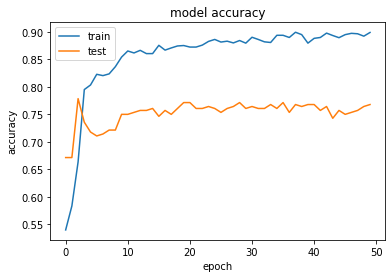

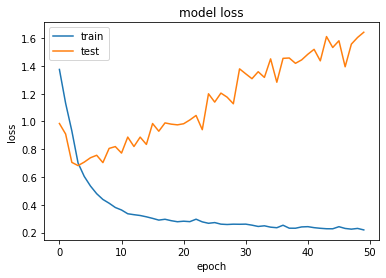

In [141]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Terlihat pola fluktuatif pada accuracy dan loss plot. Bisa jadi hal ini terjadi dikarenakan model mencapai local optima yang kemudian melakukan optimasi learning lagi. Pola subset train yang lebih baik (menurun untuk loss dan naik untuk akurasi) daripada subset test menunjukkan model tidak mengalami overfitting.

In [135]:
prediction_data.head()

,category,line
2803,MISC,This paved the way for the development of pred...
2804,MISC,"To our knowledge, the first of these methods h..."
2805,BASE,"Although our method, detailed in the following..."
2806,OWNX,By the latter we consider a seemingly trivial ...
2807,OWNX,The accuracy of the method makes it attractive...


Melakukan prediksi dengan brand-new data (prediction subset) untuk mengetahui sejauh mana tingkat akurasi model.

In [136]:
prediction_sentences = prediction_data['line'].values
prediction_sequences = tokenizer.texts_to_sequences(prediction_sentences)
prediction_padded    = pad_sequences(prediction_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)
len(prediction_sequences),len(prediction_padded)

(311, 311)

Konversi (tokenisasi) subset prediction dilakukan karena input data saat learning merupakan hasil tokenisasi (ditambah padding). Proses tokenisasi menggunakan tokenizer saat model lerning untuk mengurangi potensi data-leakage dari subset prediction (jika menggunakan tokenizer baru yang telah di-fitting dengan prediction, maka bisa jadi ada kemungkinan leakage atau error pada model dikarenakan representasi atau dimensional mapping yang berbeda)

In [139]:
prediction_result = model.predict(prediction_padded)

array([[1.5405543e-11, 9.9853599e-01, 1.1278840e-03, 9.9311102e-09,
        3.3605687e-04, 8.0477413e-08],
       [4.0123697e-15, 9.9990141e-01, 7.9168130e-05, 1.4607151e-11,
        1.9376521e-05, 2.1231208e-10],
       [2.1598472e-18, 9.9999666e-01, 6.1547570e-07, 1.1559266e-14,
        2.7306373e-06, 8.3128079e-13],
       ...,
       [9.5662145e-08, 4.4638398e-01, 5.5174708e-01, 5.2025269e-05,
        1.7831109e-03, 3.3664022e-05],
       [6.2203270e-10, 4.1212221e-03, 9.9572730e-01, 1.2741423e-04,
        2.1076195e-05, 3.0417684e-06],
       [7.0086145e-11, 6.4866379e-02, 9.3511736e-01, 3.2645148e-06,
        1.2934108e-05, 1.6414785e-07]], dtype=float32)

Hasil prediksi berupa sparse vector (List) yang menunjukkan tingkat probabilitas kategori (index mana yang tertinggi nilainya) untuk setiap data prediction. 

In [161]:
inverse = {code:name for name,code in label_tokenizer.word_index.items()}
prediction_cat = [inverse[elem.argmax()].upper() for elem in prediction_result]

Konversi dari sparse vector ke dalam kategori dengan inversi tokenizer.

In [176]:
false_pred = 0
true_pred = 0
prediction_labels = prediction_data['category'].values
for i in range(len(prediction_cat)):
    if prediction_cat[i] == prediction_labels[i]:
        true_pred += 1
    else:
        false_pred += 1
print(f"True Prediction     : {true_pred}")
print(f"False Prediction    : {false_pred}")
print(f"Accuracy            : {true_pred/len(prediction_labels):.4f}") 

True Prediction     : 143
False Prediction    : 168
Accuracy            : 0.4598


In [177]:
prediction_label_seq = np.asarray(label_tokenizer.texts_to_sequences(prediction_labels))
model.evaluate(prediction_padded,prediction_label_seq)

10/10 [==============================] - 0s 27ms/step - loss: 3.2376 - accuracy: 0.4598


[3.2375688552856445, 0.45980706810951233]

Statistik prediksi data prediction oleh model

In [168]:
model.save('my_model.h5')

Menyimpan model untuk kebutuhan mendatang sehingga tidak perlu melakukan fitting model lagi atau untuk pembanding.

# ALTERNATIF KEDEPAN

- Melakukan hyperparamter tunning pada sekuensial model dan tokenizer.
- Menerapkan stopwords dari word_cortex seperti nltk, gloVe, spaCy, dsb
- Menerapkan mekanisme stopping dan graph untuk efisiensi pada proses fitting dan model saving.
- Memakai model pre-learning seperti BERT (Transfer Learning).

